<a href="https://colab.research.google.com/github/tlysenko/CreditScoring/blob/master/Credit_Scoring_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Plan 
* **Actions undertaken to deal with the  unbalanced dataset**
* **Data Preprocessing**
  *  Importing the libraries for EDA and data cleaning 
  *  Function for downloading the data and renaming the columns
  *  Functions for data cleaning
* **Classification ML**
  *  Importing ML libraries for classification and data split
  *  Function for creating X and y
  *  Function for getting ROC_AUC score over Stratified 10 folds
  *  Defining the approach for working with missing values. 
* **GridSearchCV and Undersampling for LogisticRegression and XGBClassifier**
  * LR Oversampling
  * XGB Oversampling
  * LR Undersampling
  * XGB Undersampling
* **Data submission**
* **Conclusion**









## Actions undertaken to deal with the unbalanced dataset
* Using stratify=y parameter at train_test_split
* Using StratifiedKfold for cross validation
* Using ROC_AUC metric for scoring
* Making sure confusion matrix is resonable and Target class "1" is noticed by the algorythm
* Using penalized regression
* Use undersampling and oversampling

## Data Preprocessing



### Importing the libraries for EDA and data cleaning 

In [0]:
import pandas as pd
from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import seaborn as sns

### Function for downloading the data and renaming the columns

In [0]:
def get_data(file="scoring_train_data.csv"):
  df = pd.read_csv(file, sep=';',na_values=' ')

  def rename_cols(df):

      df = df.rename(columns = {'SeriousDlqin2yrs': 'Target',
                                          'age': 'Age',
                                          'RevolvingUtilizationOfUnsecuredLines' : 'RevUnsec',
                                          'NumberOfOpenCreditLinesAndLoans' : 'NumLoans',
                                          'NumberOfTimes90DaysLate' : '90-Late',
                                          'NumberOfTime3059DaysPastDueNotWorse': '30-59-Late',
                                          'NumberOfTime6089DaysPastDueNotWorse': '60-89-Late' ,
                                          'NumberRealEstateLoansOrLines': 'R_EstateLoans',
                                          'NumberOfDependents': 'Dependts'
                                          })
      return df

  df = rename_cols(df)
  return df

### Functions for data cleaning


In [0]:
def data_prep_remove(df):
  # remove na values
  df = df.dropna()

  # remove outliers in DebtRatio
  df = df[df.DebtRatio<=1]

  return df

def data_prep_imputers(df):
  
  imputer = Imputer(missing_values = 'NaN', strategy = 'median',axis=0)
  imputer.fit(df['MonthlyIncome'].values.reshape(-1,1))
  df['MonthlyIncome'] = imputer.transform(df['MonthlyIncome'].values.reshape(-1,1))
  
  imputer.fit(df['Dependts'].values.reshape(-1,1))
  df['Dependts'] = imputer.transform(df['Dependts'].values.reshape(-1,1))
  
  return df

## Classification ML

### Importing ML libraries for classification and data split

In [0]:
!pip install scikit-plot

from scikitplot.metrics import plot_roc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

### Function for creating X and y

In [0]:
def make_X_y(df):
  #Creating the X and y variables
  X = df.drop(['Target','Ident'], 1).values
  y = df["Target"].values

  # Spliting X and y into train and test version
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=111, stratify=y)
  
  #We can consider all variables as continuous and scale all of them 
  feature_scaler = StandardScaler()
  X_train = feature_scaler.fit_transform(X_train)
  X_test = feature_scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

def make_X_y_noscale(df):
  #Creating the X and y variables
  X = df.drop(['Target','Ident'], 1).values
  y = df["Target"].values

  # Spliting X and y into train and test version
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=111, stratify=y)

  return X_train, X_test, y_train, y_test

### Function for getting ROC_AUC score over Stratified 10 folds

In [0]:
def get_score():
  seed = 11

  results = []
  names = []
  scoring = 'roc_auc'

  for name, model in models:
        strat = StratifiedKFold(n_splits=10, random_state=seed)

        cv_results = cross_val_score(model, X_train, y_train, cv=strat, scoring=scoring)
        
        results.append(cv_results)
        names.append(name)
        
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
  return results

def get_score_xgb():
  # XGBoostClassifier algorythm has its own strategy for imputing the missing values. Let's check this out. 
  seed = 11

  results = []
  names = []
  scoring = 'roc_auc'

  for name, model in models:
    if name == 'XGB':
        strat = StratifiedKFold(n_splits=10, random_state=seed)

        cv_results = cross_val_score(model, X_train, y_train, cv=strat, scoring=scoring)
        
        results.append(cv_results)
        names.append(name)
        
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
  return results

In [0]:
seed = 11

models = []
models.append(('LR', LogisticRegression(random_state=11, solver="saga", penalty="l1", class_weight="balanced", C=1.0, max_iter=500))) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecTree', DecisionTreeClassifier())) 
models.append(('RF', RandomForestClassifier(n_estimators = 10))) 
models.append(('XGB', XGBClassifier()))

In [0]:
mod_list = []
for mod , _ in models:
  mod_list.append(mod)
mod_list.append('Cleaning')

df_boxplot = pd.DataFrame(columns=['Score', 'ML','Cleaning'])

In [0]:
def append_res_to_boxplot(results, df, cleaning):
  i = 0
  while i < len(results[0]):
    line = []
    for num, ml in zip(results, mod_list): 
      line.append([num[i],ml,cleaning])
    i = i+1
    df = df.append(pd.DataFrame(line, columns=['Score', 'ML','Cleaning']),ignore_index=True)
  return df

def append_res_to_boxplot_xgb(results, df, cleaning):
  i = 0
  while i < len(results[0]):
    line = []
    for num, ml in zip(results, ['XGB']): 
      line.append([num[i],ml,cleaning])
    i = i+1
    df = df.append(pd.DataFrame(line, columns=['Score', 'ML','Cleaning']),ignore_index=True)
  return df

## Data cleaning and ML training pipeline

### Defining the approach for working with missing values. 

Considering using Imputer or removing rows that contain NA values. 

In [0]:
# Data Clean: Remove NAs 
print('Missing values approach: Remove NAs')
df_credit = get_data()

df_credit = data_prep_remove(df_credit)

X_train, X_test, y_train, y_test = make_X_y(df_credit)

results = get_score()
df_boxplot = append_res_to_boxplot(results, df_boxplot, 'Remove NAs')

# Data Clean: No NAs preprocessing to check for XGBoostClassifier missing values approach
print('Missing values approach: No NAs preprocessing(XGB only)')
df_credit = get_data()

X_train, X_test, y_train, y_test = make_X_y(df_credit)

results = get_score_xgb()
df_boxplot = append_res_to_boxplot_xgb(results, df_boxplot, "No NAs preprocessing")

# Data Clean: Imputer 
print('Missing values approach: Imputer')

df_credit = get_data()

df_credit = data_prep_imputers(df_credit)

X_train, X_test, y_train, y_test = make_X_y(df_credit)

results = get_score()
df_boxplot = append_res_to_boxplot(results, df_boxplot, 'Imputer')

Missing values approach: Remove NAs
LR: 0.849593 (0.012480)
KNN: 0.728448 (0.012717)
DecTree: 0.606646 (0.008297)
RF: 0.773875 (0.012814)
XGB: 0.855171 (0.012028)
Missing values approach: No NAs preprocessing(XGB only)
XGB: 0.864576 (0.006937)
Missing values approach: Imputer


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


LR: 0.857142 (0.007490)
KNN: 0.743453 (0.008572)
DecTree: 0.616191 (0.008139)
RF: 0.782186 (0.008902)
XGB: 0.864503 (0.007119)


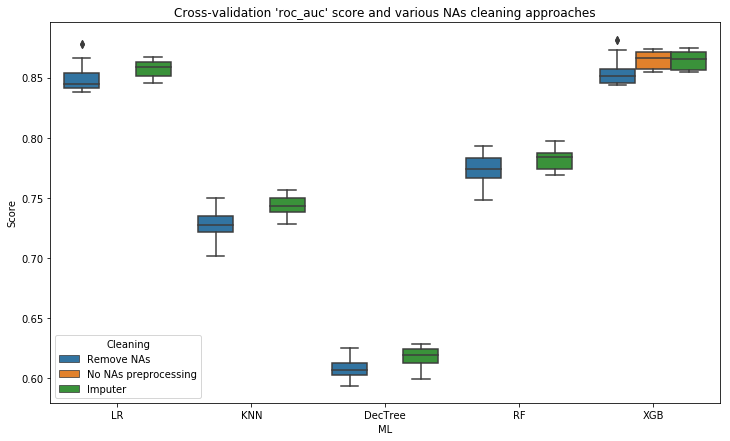

In [0]:
# Plotting the results 
plt.figure(figsize=(12,7))
plt.title("Cross-validation 'roc_auc' score and various NAs cleaning approaches")
sns.boxplot(data = df_boxplot, x = 'ML',y='Score',hue='Cleaning');

**We can see that Imputing NAs brings better results than removing them and also we can see that XGBoost internal Imputer gives equal results to sklearn Imputer so the approach for working with NAs in this dataset will be Imputing them with sklearn Imputer**

**On the other hand we can see the top three classifier to tune further:**

1.   LogisticRegression, 0.864 roc_auc
2.   XGBClassifier, 0.857 roc_auc



In [0]:
# Removing NAs according to previsously defined approach: Imputing
df_credit = get_data()

df_credit = data_prep_imputers(df_credit)

X_train, X_test, y_train, y_test = make_X_y(df_credit)

## GridSearchCV and Undersampling for LogisticRegression and XGBClassifier



# LR oversampling

In [0]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline, Pipeline

In [0]:
# Data preparation
df_credit = get_data()

df_credit = data_prep_imputers(df_credit)

X_train, X_test, y_train, y_test = make_X_y_noscale(df_credit)

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [0]:
clf_lr = LogisticRegression(class_weight = 'balanced', solver='saga',random_state=11,n_jobs=-1,C =1)
adasyn = ADASYN(random_state=11)
                
grid = {'class__max_iter': [50,100] }
pipeline = Pipeline([('sampling', adasyn), ('class', clf_lr)])

best_lr = GridSearchCV(pipeline, grid, scoring = 'roc_auc', cv = StratifiedKFold(n_splits=10, shuffle=True))

best_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        ADASYN(n_jobs=1, n_neighbors=5,
                                               random_state=11, ratio=None,
                                               sampling_strategy='auto')),
                                       ('class',
                                        LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                      

In [0]:
print("AUC Score LR ADASYN {}".format(roc_auc_score(y_test, prediction_lr)))

AUC Score LR ADASYN 0.7697287278639595


In [0]:
prediction_lr = best_lr.predict(X_test)
confusion_matrix(y_test, prediction_lr,labels=[0,1])

array([[14957,  4582],
       [  316,  1082]])

In [0]:
print("Proportion of false responses for class '0': {:.3}%".format(4528/(4528+14957)*100))


Proportion of false responses for class '0': 23.2%


In [0]:
print(classification_report(y_test, prediction_lr))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     19539
           1       0.19      0.77      0.31      1398

    accuracy                           0.77     20937
   macro avg       0.59      0.77      0.58     20937
weighted avg       0.93      0.77      0.82     20937



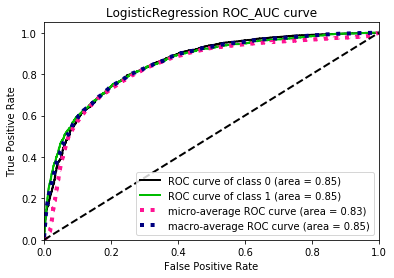

In [0]:
y_pred_proba_lr = best_lr.predict_proba(X_test)
plot_roc(y_test, y_pred_proba_lr)
plt.title('LogisticRegression ROC_AUC curve')
plt.show()

## XGB oversampling 

In [0]:
# Data preparation
df_credit = get_data()

df_credit = data_prep_imputers(df_credit)

X_train, X_test, y_train, y_test = make_X_y_noscale(df_credit)

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [0]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline, Pipeline

clf_xgb = XGBClassifier(random_state=11,n_jobs=-1)
adasyn = ADASYN(random_state=11)
                
grid = {'class__max_iter': [50,100] }
pipeline = Pipeline([('sampling', adasyn), ('class', clf_xgb)])

best_xgb = GridSearchCV(pipeline, grid, scoring = 'roc_auc', cv = StratifiedKFold(n_splits=5, shuffle=True))

best_xgb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        ADASYN(n_jobs=1, n_neighbors=5,
                                               random_state=11, ratio=None,
                                               sampling_strategy='auto')),
                                       ('class',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytre...
                                                      missing=None,
                                                      n_estimators=100,
   

In [0]:
prediction_xgb = best_xgb.predict(X_test)

In [0]:
print("AUC Score XGB ADASYN {}".format(roc_auc_score(y_test, prediction_xgb)))

AUC Score XGB ADASYN 0.7669370184468742


In [0]:
confusion_matrix(y_test, prediction_xgb,labels=[0,1])

array([[14792,  4747],
       [  312,  1086]])

In [0]:
print(classification_report(y_test, prediction_xgb))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85     19539
           1       0.19      0.78      0.30      1398

    accuracy                           0.76     20937
   macro avg       0.58      0.77      0.58     20937
weighted avg       0.93      0.76      0.82     20937



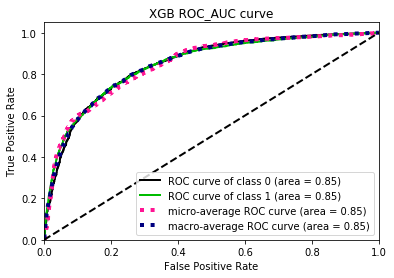

In [0]:
y_pred_proba_xgb = best_xgb.predict_proba(X_test)
scikitplot.metrics.plot_roc(y_test, y_pred_proba_xgb)
plt.title('XGB ROC_AUC curve')
plt.show()

## LR Undersampling 

In [0]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [0]:
df_credit = get_data()
df_credit = data_prep_imputers(df_credit)
X = df_credit.drop(['Ident','Target'],axis=1)
y = df_credit['Target']

#print("Original dataset shape {}".format(Counter(y)))

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_sample(X,y)
#print("Resampled dataset shape {}".format(Counter(y_resampled)))

X_train_rus, X_val_rus, y_train_rus, y_val_rus = train_test_split(X_resampled, y_resampled, random_state=42)
X_train_rus.shape, y_train_rus.shape

scaler = StandardScaler().fit(X_train_rus)
X_train_rus_scaled = scaler.transform(X_train_rus)
X_val_rus_scaled = scaler.transform(X_val_rus)

logit_resampled = LogisticRegression(random_state=42, solver="saga", penalty="l1", C=1.0, max_iter=500)
logit_resampled.fit(X_train_rus_scaled, y_train_rus)

prediction_lr_und = logit_resampled.predict(X_test)

In [0]:
print("AUC Score LR Unersampling {}".format(roc_auc_score(y_test, prediction_lr_und)))

AUC Score LR Unersampling 0.7523303233963459


In [0]:
confusion_matrix(y_test, prediction_lr_und,labels=[0,1])

array([[11971,  7568],
       [  151,  1247]])

## XGB Undersampling

In [0]:
df_credit = get_data()
df_credit = data_prep_imputers(df_credit)
X = df_credit.drop(['Ident','Target'],axis=1)
y = df_credit['Target']

#print("Original dataset shape {}".format(Counter(y)))

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_sample(X,y)
#print("Resampled dataset shape {}".format(Counter(y_resampled)))

X_train_rus, X_val_rus, y_train_rus, y_val_rus = train_test_split(X_resampled, y_resampled, random_state=42)
X_train_rus.shape, y_train_rus.shape

scaler = StandardScaler().fit(X_train_rus)
X_train_rus_scaled = scaler.transform(X_train_rus)
X_val_rus_scaled = scaler.transform(X_val_rus)

xgb_resampled = XGBClassifier(random_state=11,n_jobs=-1)
xgb_resampled.fit(X_train_rus_scaled, y_train_rus)

prediction_xgb_und = logit_resampled.predict(X_test)

In [0]:
print("AUC Score XGB Unersampling {}".format(roc_auc_score(y_test, prediction_xgb_und)))

AUC Score XGB Unersampling 0.7523303233963459


In [0]:
confusion_matrix(y_test, prediction_xgb_und,labels=[0,1])

array([[11971,  7568],
       [  151,  1247]])

# Submitting results

In [0]:
df_test = get_data("Data Scientist_1.csv")
df_test = data_prep_imputers(df_test)
df_test = df_test.drop(['Ident'],1)

df_test = feature_scaler.transform(df_test)

final_prediction = best_lr.predict(df_test)

In [0]:
# Proportion of class '1' target variable
(final_prediction ==1).sum()/len(final_prediction)

0.2628478121759086

**Suspiciously proportion of '1' values in the target variable is significantly higher than in the train dataset.** 

In [0]:
df_test = df = pd.read_csv("Data Scientist_1.csv", sep=';',na_values=' ')
df_test['SeriousDlqin2yrs'] = final_prediction

In [0]:
df_test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents,Ident,SeriousDlqin2yrs
0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,97.0,1
1,0.907239,49,1,0.024926,25000.0,7,0,1,0,0.0,214.0,1
2,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,305.0,0
3,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,601.0,1
4,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0,1817.0,0


In [0]:
df_test.to_csv('tlysenko_credit_scoring.csv')

# Выводы

Был проведен EDA и feature engineering, но новые признаки не дали более высокой корреляции с целевой переменной чем те признаки на которых они основывались. Таким образом ни один из новых признаков не попал в тренинговый датасет. 

Так как выборка несбалансированная, то были разработаны шаги по преодолению последствий такой несбалансированности.

Была оценена метрика roc_auc на стратифицированной кросс-валидации для 5 моделей LogicsticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier.

Так же на кросс-валидации оценивался оптимальный подход к обработке NA значений в переменных Dependents и MonthlyIncome. 

Следующий этап - подбор параметров с помощью  GridSearchCV, а также Oversamlpling. Для этого были выбраны две модели - XGBoostClassifer и LogicsticRegression, показавшие наилучший результат на предидущем этапе (средние значения roc_auc 0.864 и 0.857 соответственно). 

Нужно отметить, что GridSearchCV проводился формально, на минимальном наборе параметров. Это связано с временныными и вычислительными ограничениями. Для дальнейшего улучшения результата стоит значительно расширить сетку параметров. 

И следующий этап это Undersampling для XGBoostClassifer и LogicsticRegression.

Было ожидание, что undersampling, oversampling и gridsearch повысят roc_auc, но этого не произошло. Значения roc_auc после всех этих упражнений находтся в районе 0.75 и я пока не нашла ответ на вопрос "почему так ?". 

Тем не менее, на confusion matrix видно, что при undersampling количество True Positive по классу "1" существенно улучшается, но это происходит ценой, того, что почти половина предсказаний по классу "0" оказывается неправильной. Поэтому, для финального предсказания был выбран алгоритм LogisticRegression + oversampling. 

Пропорция класса "1" в prediction выборе составляет 26% по сравнению с 6.68% в тренинговой выборке. Что, в целом, было видно по confusion матрице - в 23% случаев алогритм ошибается на классе "0" на тренинговой выборке. 

Что нужно сделать дальше:
* Нужно поэксперементировать с automated feature selection
* Безусловно, нужно значительно больше выжать из XGB, тут он работает на уровне c Логистической регрессией, а он точно может больше. 
* Нужно разобраться с понижением метрики после кросс валидации. 
* Провести кросс-валидацию по более широкой сетке параметров 
